<a href="https://colab.research.google.com/github/ragul-n/LendingClubPrediction/blob/master/Loan%20Grading%20with%20Text%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Downloading data from Kaggle
Upload your Kaggle API token (kaggle.json file) below to download data directly from kaggle.

In [ ]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!kaggle datasets download -d wordsforthewise/lending-club

In [ ]:
!unzip lending-club.zip

### Reading and Clening Data

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from LoanGrader import LoanGrader

In [3]:

#columns to be used
cols= ["loan_amnt" ,'term' ,'int_rate' , 'installment' ,'grade'  ,'emp_title' ,'emp_length' ,'home_ownership' ,'annual_inc' , 'dti' ,'verification_status', 
        'pymnt_plan'  ,'purpose' ,'title' ,'zip_code' ,'addr_state' ,'dti' ,'fico_range_low' ,'fico_range_high' ,'tax_liens', 
       "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc", "mort_acc", 'application_type']



In [4]:
accepted_loans = pd.read_csv("/content/accepted_2007_to_2018Q4.csv.gz",  low_memory=False, usecols=cols)


In [5]:
accepted_loans.drop(accepted_loans.tail(2).index, inplace = True) #droping lost two rows

accepted_loans = accepted_loans[accepted_loans['application_type'] =="Individual"] #removing joint loan applications
data = accepted_loans.drop([ "application_type" ], axis=1 )

accepted_loans= accepted_loans[[(not i) for i in accepted_loans['loan_amnt'].isna()]] #removing all instances with NA values for loan amount. 

print("Loan Grades: ",sorted(accepted_loans["grade"].unique()))

Loan Grades:  ['A', 'B', 'C', 'D', 'E', 'F', 'G']


#### Imputing Missing Values

In [6]:
data=data.fillna({"emp_title": "not known", "home_ownership":"not known", "emp_length": "not known", 'title':"No title", "zip_code": "000XX"})
data=data.fillna(data.mean(numeric_only=True))

#preparing Data for training

In [7]:
data['text']=  data['emp_title'] + " " + data['purpose']+ " " + data['title']


In [8]:
data=data.drop([ 'emp_title',  'purpose', 'title'], axis=1)
data.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,zip_code,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens,text
0,3600.0,36 months,13.99,123.03,C,10+ years,MORTGAGE,55000.0,Not Verified,n,190xx,PA,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0,leadman debt_consolidation Debt consolidation
1,24700.0,36 months,11.99,820.28,C,10+ years,MORTGAGE,65000.0,Not Verified,n,577xx,SD,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0,Engineer small_business Business
3,35000.0,60 months,14.85,829.90,C,10+ years,MORTGAGE,110000.0,Source Verified,n,076xx,NJ,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0,Information Systems Officer debt_consolidation...
4,10400.0,60 months,22.45,289.91,F,3 years,MORTGAGE,104433.0,Source Verified,n,174xx,PA,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0,Contract Specialist major_purchase Major purchase
5,11950.0,36 months,13.44,405.18,C,4 years,RENT,34000.0,Source Verified,n,300xx,GA,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0,Veterinary Tecnician debt_consolidation Debt c...


#### Encoding Categorical Data

In [9]:
def encode_categorical_data(columns):
    for col in columns:
        data[col]=pd.Categorical(data[col])
        data[col]= data[col].cat.codes

encode_categorical_data(["grade", "term", "pymnt_plan", "emp_length", "verification_status", "home_ownership", "zip_code", "addr_state"])

data.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,zip_code,addr_state,dti,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,tax_liens,text
0,3600.0,0,13.99,123.03,2,1,1,55000.0,0,0,183,38,5.91,675.0,679.0,7.0,0.0,2765.0,29.7,13.0,1.0,0.0,leadman debt_consolidation Debt consolidation
1,24700.0,0,11.99,820.28,2,1,1,65000.0,0,0,555,41,16.06,715.0,719.0,22.0,0.0,21470.0,19.2,38.0,4.0,0.0,Engineer small_business Business
3,35000.0,1,14.85,829.90,2,1,1,110000.0,1,0,70,31,17.06,785.0,789.0,13.0,0.0,7802.0,11.6,17.0,1.0,0.0,Information Systems Officer debt_consolidation...
4,10400.0,1,22.45,289.91,5,3,1,104433.0,1,0,167,38,25.37,695.0,699.0,12.0,0.0,21929.0,64.5,35.0,6.0,0.0,Contract Specialist major_purchase Major purchase
5,11950.0,0,13.44,405.18,2,4,5,34000.0,1,0,291,10,10.20,690.0,694.0,5.0,0.0,8822.0,68.4,6.0,0.0,0.0,Veterinary Tecnician debt_consolidation Debt c...


#### Tokenizing Text Data

In [10]:
#Preparig text data to fit tokenizer
texts=list(data['text'])
modified_text=[]

for i in range(len(data['text'])):
    str= texts[i].replace('_', ' ')
    modified_text.append(str)
data['text']= modified_text

#fitting text data on tokenizer
tokenizer= tf.keras.preprocessing.text.Tokenizer(lower=True, split=' ', oov_token=1)
tokenizer.fit_on_texts(data['text'])


In [11]:
#tokenizing text data
sequence= tokenizer.texts_to_sequences(data['text'])
sequence= tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post', value=0 )
data['sequence']=list(sequence)

#### Splitting dataset into Training, Validation and Test sets

>  Training set: 80% \\
   Validation set: 10% \\
   Test set: 10%








In [12]:

y= data['grade']
x=data.drop(['text', "grade"], axis=1)


x_train, x_test,y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=1)

x_test, x_val,y_test, y_val= train_test_split(x_test, y_test, test_size=0.5, random_state=1)


In [13]:
train_sequence= list(x_train['sequence'])
test_sequence= list(x_test['sequence'])
val_sequence= list(x_val['sequence'])

x_train= x_train.drop('sequence', axis=1 )
x_test= x_test.drop('sequence', axis=1)
x_val= x_val.drop('sequence', axis=1)

In [14]:
#normalizing datasets
x_train=(x_train-x_train.mean())/x_train.std()
x_val=(x_val-x_val.mean())/x_val.std()
x_test=(x_test-x_test.mean())/x_test.std()

In [15]:
#Using Tesorflow Dataset API to make input pipeline much more effecient 
training_data= tf.data.Dataset.from_tensor_slices((x_train.values, train_sequence, y_train.values))
validation_data= tf.data.Dataset.from_tensor_slices((x_val.values, val_sequence,y_val.values))
test_data= tf.data.Dataset.from_tensor_slices((x_test.values, test_sequence, y_test.values))

In [16]:
training_data= training_data.batch(256)
validation_data=validation_data.batch(513)
test_data= test_data.batch(512)

#Training Model

In [17]:
 with tf.device('/GPU:0'): 
    model= LoanGrader(2, 128, 4, 256, max_positional_encoding=25)


In [18]:
for x, seq, y in training_data:
    model(x, seq)
    break

model.summary()

Model: "loan_grader"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  11093376  
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  412416    
_________________________________________________________________
dense_13 (Dense)             multiple                  8256      
_________________________________________________________________
dense_14 (Dense)             multiple                  4160      
_________________________________________________________________
dense_15 (Dense)             multiple                  

In [19]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([ 0.74388348,  0.48534454,  0.49873275,  1.0001332 ,  2.36852292,
        7.65179186, 26.68775332])

In [20]:

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer)

In [21]:

with tf.device('/GPU:0'): 
    model.train(training_data, epochs=20, validation_data=validation_data) 

Epoch  1  :


'     100% Compleated  | Loss 0.3776 | Accuracy 83.51% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.3166 Accuracy | 84.71% | Time: 0.0 mins'

Epoch  2  :


'     100% Compleated  | Loss 0.2969 | Accuracy 86.61% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.3066 Accuracy | 85.46% | Time: 0.0 mins'

Epoch  3  :


'     100% Compleated  | Loss 0.2767 | Accuracy 87.51% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2747 Accuracy | 87.43% | Time: 0.0 mins'

Epoch  4  :


'     100% Compleated  | Loss 0.2644 | Accuracy 87.99% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2869 Accuracy | 86.86% | Time: 0.0 mins'

Epoch  5  :


'     100% Compleated  | Loss 0.2501 | Accuracy 88.58% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2649 Accuracy | 87.76% | Time: 0.0 mins'

Epoch  6  :


'     100% Compleated  | Loss 0.2389 | Accuracy 89.14% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2657 Accuracy | 87.82% | Time: 0.0 mins'

Epoch  7  :


'     100% Compleated  | Loss 0.2321 | Accuracy 89.46% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2684 Accuracy | 87.82% | Time: 0.0 mins'

Epoch  8  :


'     100% Compleated  | Loss 0.2248 | Accuracy 89.81% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2477 Accuracy | 88.72% | Time: 0.0 mins'

Epoch  9  :


'     100% Compleated  | Loss 0.2193 | Accuracy 90.09% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2486 Accuracy | 88.88% | Time: 0.0 mins'

Epoch  10  :


'     100% Compleated  | Loss 0.2151 | Accuracy 90.29% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2293 Accuracy | 89.84% | Time: 0.0 mins'

Epoch  11  :


'     100% Compleated  | Loss 0.2119 | Accuracy 90.45% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2438 Accuracy | 89.00% | Time: 0.0 mins'

Epoch  12  :


'     100% Compleated  | Loss 0.2090 | Accuracy 90.62% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2399 Accuracy | 89.52% | Time: 0.0 mins'

Epoch  13  :


'     100% Compleated  | Loss 0.2069 | Accuracy 90.71% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2334 Accuracy | 89.59% | Time: 0.0 mins'

Epoch  14  :


'     100% Compleated  | Loss 0.2041 | Accuracy 90.85% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2342 Accuracy | 89.86% | Time: 0.0 mins'

Epoch  15  :


'     100% Compleated  | Loss 0.2016 | Accuracy 90.98% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2302 Accuracy | 89.98% | Time: 0.0 mins'

Epoch  16  :


'     100% Compleated  | Loss 0.1997 | Accuracy 91.08% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2296 Accuracy | 89.93% | Time: 0.0 mins'

Epoch  17  :


'     100% Compleated  | Loss 0.1970 | Accuracy 91.19% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2276 Accuracy | 90.02% | Time: 0.0 mins'

Epoch  18  :


'     100% Compleated  | Loss 0.1946 | Accuracy 91.30% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2202 Accuracy | 90.59% | Time: 0.0 mins'

Epoch  19  :


'     100% Compleated  | Loss 0.1918 | Accuracy 91.42% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2316 Accuracy | 89.94% | Time: 0.0 mins'

Epoch  20  :


'     100% Compleated  | Loss 0.1888 | Accuracy 91.54% | Time: 4.0 mins'

'   Validation: 100% Compleated | Loss 0.2268 Accuracy | 90.39% | Time: 0.0 mins'

In [22]:
accuracy, loss= model.evaluate(test_data)

print(f"Accuracy: {accuracy:.2f}")
print(f"Loss: {loss:.4f}")

Accuracy: 0.90
Loss: 0.2487


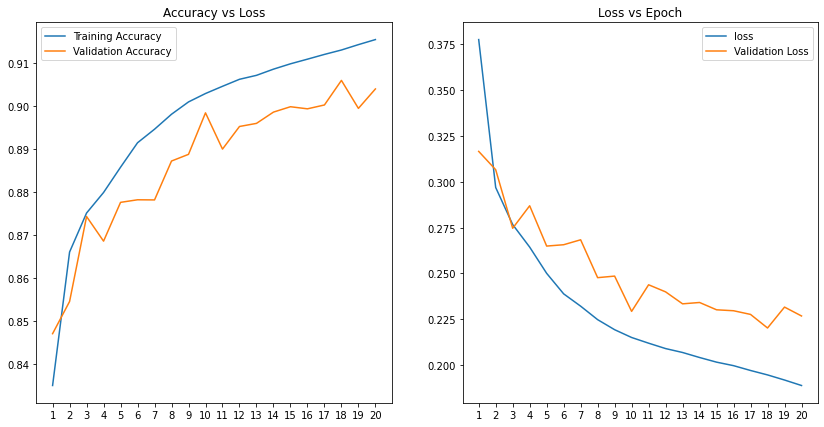

In [46]:

fig, [accuracy, loss]= plt.subplots(ncols=2, figsize=(14,7))

accuracy.plot( range(1,21,1), model.training_history[ 'training_loss'][1::2], label="Training Accuracy")
accuracy.plot( range(1,21,1), model.training_history['validation_accuracy'],  label= "Validation Accuracy")
accuracy.legend()
accuracy.set_xticks(range(1,21,1))
accuracy.set_title("Accuracy vs Loss")

loss.plot( range(1,21,1), model.training_history[ 'training_loss'][0:-1:2], label="loss")
loss.plot( range(1,21,1), model.training_history['validation_loss'], label="Validation Loss")
loss.legend()
loss.set_title("Loss vs Epoch")
loss.set_xticks(range(1,21,1))
plt.show()